In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

<h1> Functionalizing the sanity check / scaling plots </h1>

These provide nice visualization of how well the model is doing given a batch_example and a channel to look at.  Gives tangible visual of what loss function means as well as providing a way to sanity check what the thing is doing (debugging, etc)

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model Class

In [4]:
class Conv1dAutoencoder(torch.nn.Module):
    """
    A causal implementation of Conv1d
    """
    def __init__(self, in_channels, out_channels, out_timesteps = 1,
                 kernel_size=1, stride=1, dilation=1, bias=True, c = 1):
        super(Conv1dAutoencoder, self).__init__()
        
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride = stride
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.h = out_timesteps
        self.c = c

        self.conv = torch.nn.Conv1d(in_channels= in_channels, 
                                    out_channels = out_channels * out_timesteps,
                                    kernel_size=kernel_size, 
                                    stride=stride,
                                    dilation=dilation, 
                                    bias=bias)

    def forward(self, signal,time=None):
        # get sizes
        batch_size = signal.shape[0]
        num_chans  = signal.shape[1]
        seq_len    = signal.shape[2]
        
        # prep inputs
        X = self.shape_inputs(signal)
        
        # prep targets
        targets = self.shape_targets(signal)
        
        # make preds and reshape them to fit targets
        preds = self.conv(X)
        preds = self.reshape_preds(preds)
        
        # create time if necessary and reshape to fit targets
        time = torch.arange(seq_len) if time is None else time
        out_time = self.shape_out_time(time)

        return X, preds, targets, out_time
    
    def shape_inputs(self,signal):
        # pad so that it's causal
        padding = (int((self.kernel_size - 1) * (self.dilation)), 0)
        X = torch.nn.functional.pad(signal, padding)
        # remove timesteps that we won't have predictions for
        truncate = self.c + self.h - 1
        X = X[:,:,:-truncate]
        return X  
    
    def reshape_preds(self,preds):
        preds = preds.view(1,self.in_channels,self.h,-1)
        preds = preds.permute((0,1,3,2))
        return preds
    
    def shape_targets(self,signal):
        future_vals = signal[:,:,self.c:] # all but the first
        targets = torch_running_view(future_vals,self.h) # reshape to have a 4th dimension
        targets = targets[:,:,::self.stride] # sample according to striding
        return targets
    
    def shape_out_time(self,time):
        roll_window_len = self.h
        truncate = self.c
        out_time = torch_running_view(time[truncate:],roll_window_len)
        return out_time[::self.stride]
            

In [5]:
def torch_running_view(tensor,window,axis=-1):
    shape = list(tensor.shape)
    shape[axis] -= (window -1)
    assert(shape[axis]>0)
    return torch.as_strided(tensor, shape + [window], 
                            tensor.stride() + (tensor.stride()[axis],))

# data examples

## examples 1 and 2

In [6]:
seq_len = 6
channels = 2

example1 = torch.zeros((1,channels,seq_len)) + torch.arange(seq_len).float() * 10
example1[:,1] = example1[:,1] + 5
print(f'1st Example:\n{example1}\n{example1.shape}\n')

example2 = example1 + 100
print(f'2nd Example:\n{example2}\n{example2.shape}\n')

examples = torch.cat((example1, example2), 0)
print(f'Batched Examples:\n{examples}\n{examples.shape}')

1st Example:
tensor([[[ 0., 10., 20., 30., 40., 50.],
         [ 5., 15., 25., 35., 45., 55.]]])
torch.Size([1, 2, 6])

2nd Example:
tensor([[[100., 110., 120., 130., 140., 150.],
         [105., 115., 125., 135., 145., 155.]]])
torch.Size([1, 2, 6])

Batched Examples:
tensor([[[  0.,  10.,  20.,  30.,  40.,  50.],
         [  5.,  15.,  25.,  35.,  45.,  55.]],

        [[100., 110., 120., 130., 140., 150.],
         [105., 115., 125., 135., 145., 155.]]])
torch.Size([2, 2, 6])


## run it

### only 1 output per input

In [122]:
kernel_size = 2
dilation = 2
stride = 1
in_channels = 2
out_channels = in_channels # autoencoder remember
# new
out_timesteps = 1

model = Conv1dAutoencoder(in_channels = in_channels, 
                         # new
                         out_channels = out_channels,
                          out_timesteps = out_timesteps,
                         kernel_size = kernel_size, 
                         bias = False,
                         dilation = dilation,
                         stride = stride)

model.conv.weight.data = torch.ones(out_channels * out_timesteps,in_channels,kernel_size)

seq_len = 10
example4 = torch.zeros((1,2,seq_len)) + torch.arange(seq_len).float() * 10
example4[:,1] = example4[:,1] + 5
print(f'4th Example:\n{example4}\n{example4.shape}\n')

X, preds, targets, out_time = model(example4)



print(f'X:\n{X}\n{X.shape}\n')
print(f'PREDS:\n{preds}\n{preds.shape}\n')
print(f'TARGETS:\n{targets}\n{targets.shape}\n')
print(f'RESHAPED TIME:\n{out_time}\n{out_time.shape}')

4th Example:
tensor([[[ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.],
         [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.]]])
torch.Size([1, 2, 10])

X:
tensor([[[ 0.,  0.,  0., 10., 20., 30., 40., 50., 60., 70., 80.],
         [ 0.,  0.,  5., 15., 25., 35., 45., 55., 65., 75., 85.]]])
torch.Size([1, 2, 11])

PREDS:
tensor([[[[  5.],
          [ 25.],
          [ 50.],
          [ 90.],
          [130.],
          [170.],
          [210.],
          [250.],
          [290.]],

         [[  5.],
          [ 25.],
          [ 50.],
          [ 90.],
          [130.],
          [170.],
          [210.],
          [250.],
          [290.]]]], grad_fn=<PermuteBackward>)
torch.Size([1, 2, 9, 1])

TARGETS:
tensor([[[[10.],
          [20.],
          [30.],
          [40.],
          [50.],
          [60.],
          [70.],
          [80.],
          [90.]],

         [[15.],
          [25.],
          [35.],
          [45.],
          [55.],
          [65.],
          [75.],
      

choose the batch and channel and 

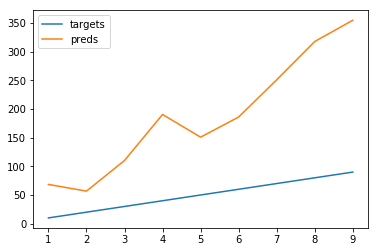

In [8]:
# choose example (right now it just a batch of one so it's 
# kind of redundant but it typically wont be)
example_idx = 0
channel_idx = 0

ex_preds   = preds[example_idx,channel_idx]
ex_targets = targets[example_idx,channel_idx]

# since h = 1, we can just collapse the outputs to 1 dim before plot them
ex_preds   = ex_preds.squeeze().detach()
ex_targets = ex_targets.squeeze()

# gonna jitter the preds so that the plot looks like it would
ex_preds = ex_preds + torch.rand(ex_preds.shape) * ex_preds.mean()

plt.plot(out_time,ex_targets)
plt.plot(out_time,ex_preds)
plt.legend(['targets','preds'])

### multi output per input

In [9]:
kernel_size = 2
dilation = 2
stride = 1
in_channels = 2
out_channels = in_channels # autoencoder remember
# new
out_timesteps = 10

model = Conv1dAutoencoder(in_channels = in_channels, 
                         # new
                         out_channels = out_channels,
                          out_timesteps = out_timesteps,
                         kernel_size = kernel_size, 
                         bias = False,
                         dilation = dilation,
                         stride = stride)

model.conv.weight.data = torch.ones(out_channels * out_timesteps,in_channels,kernel_size)

seq_len = 30
example4 = torch.zeros((1,2,seq_len)) + torch.arange(seq_len).float() * 10
example4[:,1] = example4[:,1] + 5
print(f'4th Example:\n{example4}\n{example4.shape}\n')

X, preds, targets, out_time = model(example4)



print(f'X:\n{X}\n{X.shape}\n')
print(f'PREDS:\n{preds}\n{preds.shape}\n')
print(f'TARGETS:\n{targets}\n{targets.shape}\n')
print(f'RESHAPED TIME:\n{out_time}\n{out_time.shape}')

4th Example:
tensor([[[  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
          110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
          220., 230., 240., 250., 260., 270., 280., 290.],
         [  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
          115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
          225., 235., 245., 255., 265., 275., 285., 295.]]])
torch.Size([1, 2, 30])

X:
tensor([[[  0.,   0.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,
           90., 100., 110., 120., 130., 140., 150., 160., 170., 180., 190.],
         [  0.,   0.,   5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,
           95., 105., 115., 125., 135., 145., 155., 165., 175., 185., 195.]]])
torch.Size([1, 2, 22])

PREDS:
tensor([[[[  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.],
          [ 25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.],
          [ 50.,  50.,  50.,  50.,  50.,  50.,  50., 

a lot of redundancies in the targets

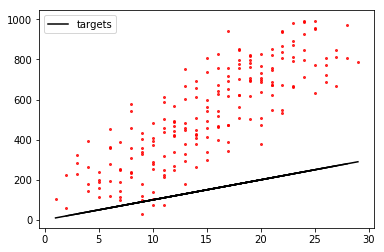

In [10]:
# choose example (right now it just a batch of one so it's 
# kind of redundant but it typically wont be)
example_idx = 0
channel_idx = 0

ex_preds   = preds[example_idx,channel_idx]
ex_targets = targets[example_idx,channel_idx]

# since h = 1, we can just collapse the outputs to 1 dim before plot them
ex_preds   = ex_preds.detach()#.squeeze()
# ex_targets = ex_targets

# gonna jitter the preds so that the plot looks like it would
ex_preds = ex_preds + torch.rand(ex_preds.shape) * ex_preds.mean()

plt.plot(out_time,ex_targets,c='k')
plt.scatter(out_time,ex_preds,s=4,c='r',alpha=0.8)
plt.legend(['targets'])

Note without the jittering

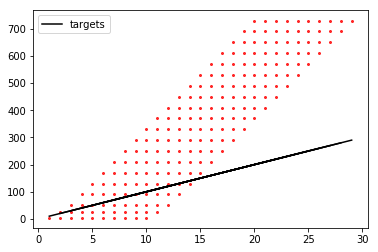

In [11]:
# choose example (right now it just a batch of one so it's 
# kind of redundant but it typically wont be)
example_idx = 0
channel_idx = 0

ex_preds   = preds[example_idx,channel_idx]
ex_targets = targets[example_idx,channel_idx]

# since h = 1, we can just collapse the outputs to 1 dim before plot them
ex_preds   = ex_preds.detach()#.squeeze()
# ex_targets = ex_targets

# gonna jitter the preds so that the plot looks like it would
# ex_preds = ex_preds + torch.rand(ex_preds.shape) * ex_preds.mean()

plt.plot(out_time,ex_targets,c='k')
plt.scatter(out_time,ex_preds,s=4,c='r',alpha=0.8)
plt.legend(['targets'])

# Function to handle plotting

In [12]:
def plot_preds(out_time, preds, targets, h, example_idx=0, channel_idx=0,
              markersize = 4, pred_color = 'r', target_color = 'k', alpha = 0.8):
    '''Plots two line plots if not stacked and a scatter plot for preds if it is'''
    # select batch_example and channel, detach preds if necessary
    ex_preds   = preds[example_idx,channel_idx].detach()
    ex_targets = targets[example_idx,channel_idx]
    
    if h == 1:
        # plot line graphs after squeezing the redundant output out
        ex_preds   = ex_preds.squeeze()
        ex_targets = ex_targets.squeeze()
        plt.plot(out_time,ex_targets,c=target_color)
        plt.plot(out_time,ex_preds,c=pred_color)
        plt.legend(['targets','preds'])
        return
    else:
        # plot line for targets and scatter for preds
        plt.plot(out_time,ex_targets,c=target_color)
        plt.scatter(out_time,ex_preds,s=markersize,c=pred_color,alpha=alpha)
        plt.legend(['targets'])
        return

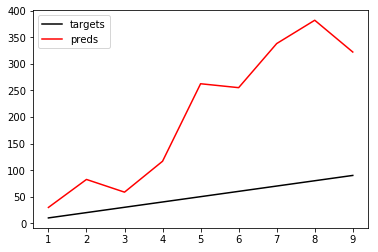

In [123]:
preds_jittered = preds + torch.rand(preds.shape) * preds.mean()
plot_preds(out_time,preds_jittered,targets,out_timesteps)

# 2nd function to plot based on length from present

Maybe I want to see how well I'm doing in the distant future vs the nearest to present

## multi output example
note it only makes sense on multi-output

In [14]:
kernel_size = 2
dilation = 2
stride = 1
in_channels = 2
out_channels = in_channels # autoencoder remember
# new
out_timesteps = 10

model = Conv1dAutoencoder(in_channels = in_channels, 
                         # new
                         out_channels = out_channels,
                          out_timesteps = out_timesteps,
                         kernel_size = kernel_size, 
                         bias = False,
                         dilation = dilation,
                         stride = stride)

model.conv.weight.data = torch.ones(out_channels * out_timesteps,in_channels,kernel_size)

seq_len = 30
example4 = torch.zeros((1,2,seq_len)) + torch.arange(seq_len).float() * 10
example4[:,1] = example4[:,1] + 5
print(f'4th Example:\n{example4}\n{example4.shape}\n')

X, preds, targets, out_time = model(example4)



print(f'X:\n{X}\n{X.shape}\n')
print(f'PREDS:\n{preds}\n{preds.shape}\n')
print(f'TARGETS:\n{targets}\n{targets.shape}\n')
print(f'RESHAPED TIME:\n{out_time}\n{out_time.shape}')

4th Example:
tensor([[[  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
          110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
          220., 230., 240., 250., 260., 270., 280., 290.],
         [  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
          115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
          225., 235., 245., 255., 265., 275., 285., 295.]]])
torch.Size([1, 2, 30])

X:
tensor([[[  0.,   0.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,
           90., 100., 110., 120., 130., 140., 150., 160., 170., 180., 190.],
         [  0.,   0.,   5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,
           95., 105., 115., 125., 135., 145., 155., 165., 175., 185., 195.]]])
torch.Size([1, 2, 22])

PREDS:
tensor([[[[  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.],
          [ 25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.],
          [ 50.,  50.,  50.,  50.,  50.,  50.,  50., 

## test plot
only want to select a few lines, lets choose the first "0th" (closest to present), 5th, and the farthest idx = 9

In [15]:
out_timesteps

10

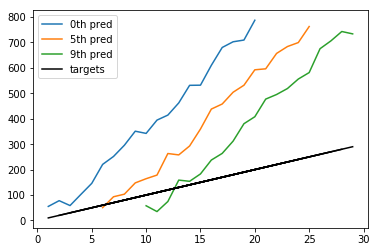

In [16]:
# choose example (right now it just a batch of one so it's 
# kind of redundant but it typically wont be)
example_idx = 0
channel_idx = 0

ex_preds   = preds[example_idx,channel_idx]
ex_targets = targets[example_idx,channel_idx]

# since h = 1, we can just collapse the outputs to 1 dim before plot them
ex_preds   = ex_preds.detach()#.squeeze()
# ex_targets = ex_targets

# gonna jitter the preds so that the plot looks like it would
ex_preds = ex_preds + torch.rand(ex_preds.shape) * ex_preds.mean()/5



# predictions I'm interested in
hs = [0,5,9]
# plot prediction lines
for i in hs:
    plt.plot(out_time[:,i],ex_preds[:,i])
    
# plot target line
plt.plot(out_time,ex_targets,c='k')
leg = [f'{dist}th pred' for dist in hs]
leg.append('targets')

plt.legend(leg)

#### 9th prediction numbers
sanity check

In [17]:
ex_preds[:,i]

tensor([ 57.8075,  34.9660,  74.5502, 158.6773, 153.9699, 183.0290, 237.5787,
        263.7527, 311.9440, 380.5040, 407.9130, 477.2410, 495.3309, 518.8041,
        556.1259, 581.5952, 675.4694, 706.2488, 743.0825, 733.7646])

In [18]:
out_time[:,i]

tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29])

## function

In [19]:
def plot_multi_pred_lines(out_time, preds, targets, hs = [0], example_idx=0, channel_idx=0):
    '''hs are a list of indices all of which must be less than h of the model'''
    # select batch_example and channel, detach preds if necessary
    ex_preds   = preds[example_idx,channel_idx].detach()
    ex_targets = targets[example_idx,channel_idx]
    
    # plot prediction lines
    for i in hs:
        plt.plot(out_time[:,i],ex_preds[:,i])

    # plot target line
    plt.plot(out_time,ex_targets,c='k')
    # create legend
    leg = [f'{dist}th pred' for dist in hs]
    leg.append('targets')
    plt.legend(leg)
    return

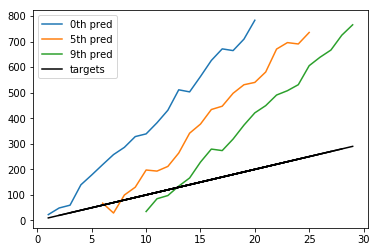

In [20]:
preds_jittered = preds + torch.rand(preds.shape) * preds.mean()/5
plot_multi_pred_lines(out_time,preds_jittered,targets,hs=[0,5,9])

# Actual Functions for implementation

Combines the two of above but brings "if" statement out of function

## Multi-preds

### Create example

In [133]:
kernel_size = 2
dilation = 2
stride = 1
in_channels = 2
out_channels = in_channels # autoencoder remember
# new
out_timesteps = 10

model = Conv1dAutoencoder(in_channels = in_channels, 
                         # new
                         out_channels = out_channels,
                          out_timesteps = out_timesteps,
                         kernel_size = kernel_size, 
                         bias = False,
                         dilation = dilation,
                         stride = stride)

# model.conv.weight.data = torch.ones(out_channels * out_timesteps,in_channels,kernel_size)

seq_len = 30
example4 = torch.zeros((1,2,seq_len)) + torch.arange(seq_len).float() * 10
example4[:,1] = example4[:,1] + 5
print(f'4th Example:\n{example4}\n{example4.shape}\n')

X, preds, targets, out_time = model(example4)

4th Example:
tensor([[[  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
          110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
          220., 230., 240., 250., 260., 270., 280., 290.],
         [  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
          115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
          225., 235., 245., 255., 265., 275., 285., 295.]]])
torch.Size([1, 2, 30])



(0, 800)

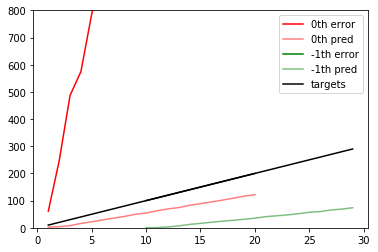

In [135]:
def plot_multi_errors(out_time, preds, targets, hs = {0:'r',-1:'g'}, example_idx=0, channel_idx=0, plot_preds = True,
                      markersize = 4, pred_color = 'r', target_color = 'k', alpha = 0.5):
    h_idxs = list(hs.keys())
    # select batch_example and channel, detach preds if necessary
    ex_preds   = preds[example_idx,channel_idx,:,h_idxs].detach()
    ex_targets = targets[example_idx,channel_idx,:,h_idxs]
    ex_times = out_time[:,h_idxs]
    # calculate errors
    square_errs = instantaneous_se(ex_preds,ex_targets)
    
    # plot prediction lines for each h
    for i in range(len(h_idxs)):
        color = hs[h_idxs[i]]
        # plot errors
        plt.plot(ex_times[:,i], square_errs[:,i], c = color)
        # plot values
        if plot_preds: plt.plot(ex_times[:,i], ex_preds[:,i], c = color, alpha = 0.5)
    
    # plot target line
    plt.plot(ex_times,ex_targets,c=target_color)
    
    # format legend
    leg = []
    for dist in h_idxs:
        leg.append(f'{dist}th error')
        if plot_preds: leg.append(f'{dist}th pred')
    leg.append('targets')
    plt.legend(leg)
    return

preds_jittered = preds + torch.rand(preds.shape) * preds.mean()/5
plot_multi_errors(out_time,preds_jittered,targets)
plt.ylim([0,800])

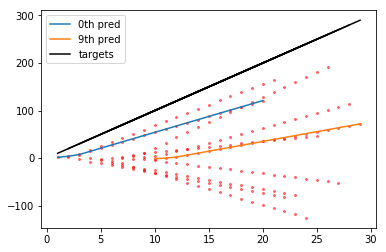

In [138]:
def plot_multi_preds(out_time, preds, targets, hs = [0,-1], example_idx=0, channel_idx=0,
                    markersize = 4, pred_color = 'r', target_color = 'k', alpha = 0.5):
    '''same as above with dots also'''
    # select batch_example and channel, detach preds if necessary
    ex_preds   = preds[example_idx,channel_idx].detach()
    ex_targets = targets[example_idx,channel_idx]
    
    # plot prediction lines for each h
    for i in hs: plt.plot(out_time[:,i],ex_preds[:,i])
    # plot scatter for preds
    plt.scatter(out_time,ex_preds,s=markersize,c=pred_color,alpha=alpha)
    # plot target line
    plt.plot(out_time,ex_targets,c=target_color)
    
    # create legend
    leg = [f'{dist}th pred' for dist in hs]
    leg.append('targets')
    plt.legend(leg)
    return
# preds_jittered = preds + torch.rand(preds.shape) * preds.mean()/5
plot_multi_preds(out_time,preds,targets,hs=[0,9])

## Single Preds

Again same as above but without 

### h = 1 targets and preds example generated

In [140]:
kernel_size = 2
dilation = 2
stride = 1
in_channels = 2
out_channels = in_channels # autoencoder remember
# new
out_timesteps = 1

model = Conv1dAutoencoder(in_channels = in_channels, 
                         # new
                         out_channels = out_channels,
                          out_timesteps = out_timesteps,
                         kernel_size = kernel_size, 
                         bias = False,
                         dilation = dilation,
                         stride = stride)

# model.conv.weight.data = torch.ones(out_channels * out_timesteps,in_channels,kernel_size)

seq_len = 10
example4 = torch.zeros((1,2,seq_len)) + torch.arange(seq_len).float() * 10
example4[:,1] = example4[:,1] + 5
print(f'4th Example:\n{example4}\n{example4.shape}\n')

X, preds, targets, out_time = model(example4)

4th Example:
tensor([[[ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.],
         [ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.]]])
torch.Size([1, 2, 10])



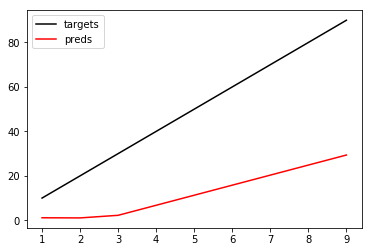

In [141]:
def plot_single_pred(out_time, preds, targets, h, example_idx=0, channel_idx=0,
              markersize = 4, pred_color = 'r', target_color = 'k', alpha = 0.8):
    '''Plots two line plots if not stacked and a scatter plot for preds if it is'''
    # select batch_example and channel, detach preds if necessary
    ex_preds   = preds[example_idx,channel_idx].detach()
    ex_targets = targets[example_idx,channel_idx]

    # plot line graphs after squeezing the redundant output out
    ex_preds   = ex_preds.squeeze()
    ex_targets = ex_targets.squeeze()
    plt.plot(out_time,ex_targets,c=target_color)
    plt.plot(out_time,ex_preds,c=pred_color)
    plt.legend(['targets','preds'])
    return
# preds_jittered = preds + torch.rand(preds.shape) * preds.mean()
plot_single_pred(out_time,preds,targets,out_timesteps)

Accuracy or RMSE at different steps

I dont think the above will work for really long noisy (stationary) signals... real data wont be as easy to visualize in just one channel

HOWEVER, I think the L2 norm of loss over all channels would be useful wrt to time if I had a sense of what was happening at those times